# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [113]:
import numpy as np
import os
from skimage import io,transform

import datetime


In [141]:
tf. __version__

'2.14.0'

We set the random seed so that the results don't vary drastically.

In [114]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [115]:
train_doc = np.random.permutation(open('/Users/rishismac/Downloads/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/rishismac/Downloads/Project_data/val.csv').readlines())
batch_size =33

In [120]:
train_doc=train_doc[:660]
val_doc=val_doc[:99]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [122]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = 20
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    resizedImage = transform.resize(image, (100, 100,3))

                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    
                    batch_data[folder,idx,:,:,0] = (resizedImage[:,:,0]-np.min(resizedImage[:,:,0]))/((np.max(resizedImage[:,:,0])-np.min(resizedImage[:,:,0])))
                    batch_data[folder,idx,:,:,1] = (resizedImage[:,:,1]-np.min(resizedImage[:,:,1]))/((np.max(resizedImage[:,:,1])-np.min(resizedImage[:,:,1])))
                    batch_data[folder,idx,:,:,2] = (resizedImage[:,:,2]-np.min(resizedImage[:,:,2]))/((np.max(resizedImage[:,:,2])-np.min(resizedImage[:,:,2])))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [123]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/rishismac/Downloads/Project_data/train'
val_path = '/Users/rishismac/Downloads/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 660
# validation sequences = 99
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [124]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



In [80]:
help(Conv3D)

Help on class Conv3D in module keras.src.layers.convolutional.conv3d:

class Conv3D(keras.src.layers.convolutional.base_conv.Conv)
 |  Conv3D(filters, kernel_size, strides=(1, 1, 1), padding='valid', data_format=None, dilation_rate=(1, 1, 1), groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  3D convolution layer (e.g. spatial convolution over volumes).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers or `None`, does not include th

In [125]:
model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=(15,100,100,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(5,activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [126]:
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 15, 100, 100, 16   400       
                             )                                   
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 7, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_29 (Conv3D)          (None, 7, 50, 50, 32)     4128      
                                                                 
 max_pooling3d_28 (MaxPooli  (None, 3, 25, 25, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_30 (Conv3D)          (None, 3, 25, 25, 64)     16448     
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [127]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [60]:
batch,labels=next(train_generator)


Source path =  /Users/rishismac/Downloads/Project_data/train ; batch size = 33


In [ ]:
batch.shape,labels.shape

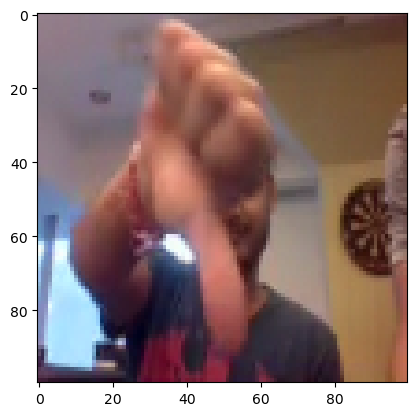

In [144]:
plt.imshow(batch[0][6])

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [131]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [132]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/9x/4xp41zzn79j2sgnc93pkddq80000gn/T/ipykernel_21546/215571741.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.9822 - accuracy: 0.6182Source path =  /Users/rishismac/Downloads/Project_data/val ; batch size = 33


2024-05-23 16:58:23.938718: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: IndexError: index 99 is out of bounds for axis 0 with size 99
Traceback (most recent call last):

  File "/Users/rishismac/anaconda3/lib/python3.11/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/Users/rishismac/anaconda3/lib/python3.11/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/Users/rishismac/anaconda3/lib/python3.11/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/Users/rishismac/anaconda3/lib/python3.11/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/var/folders/9x/

20/20 [==============================] - 92s 5s/step - loss: 0.9822 - accuracy: 0.6182 - val_loss: 0.9936 - val_accuracy: 0.6263
Epoch 2/20
20/20 [==============================] - 85s 4s/step - loss: 0.8332 - accuracy: 0.6939
Epoch 3/20
20/20 [==============================] - 81s 4s/step - loss: 0.6237 - accuracy: 0.7864
Epoch 4/20
20/20 [==============================] - 88s 4s/step - loss: 0.3708 - accuracy: 0.8652
Epoch 5/20
20/20 [==============================] - 80s 4s/step - loss: 0.2357 - accuracy: 0.9333
Epoch 6/20
20/20 [==============================] - 80s 4s/step - loss: 0.1248 - accuracy: 0.9697
Epoch 7/20
20/20 [==============================] - 85s 4s/step - loss: 0.0785 - accuracy: 0.9864
Epoch 8/20
20/20 [==============================] - 85s 4s/step - loss: 0.0468 - accuracy: 0.9894
Epoch 9/20
 5/20 [======>.......................] - ETA: 1:00 - loss: 0.0315 - accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
#To make sure that you have "at least steps_per_epoch * epochs batches", set the steps_per_epoch to

steps_per_epoch = len(X_train)//batch_size

validation_steps = len(X_test)//batch_size # if you have validation data 
